# Jupyter Notebook: Parsing an API and Visualizing Orbit Path Data

In this notebook, we will load an API, convert it to a pandas DataFrame, and then create visualizations using geopandas.

In [7]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['geopandas'])
await piplite.install(['numpy'])
await piplite.install(['requests'])

In [8]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

## Step 1: Retrieve Data from the API

In [9]:
# API URL for satellite TLE data
url = "https://tle.ivanstanojevic.me/api/tle/25544"

# Make an API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    tle_data = response.json()  # Parse JSON response
else:
    print(f"Failed to retrieve data: {response.status_code}")

# Extract the relevant fields
satellite_data = {
    'satelliteId': tle_data['satelliteId'],
    'name': tle_data['name'],
    'date': tle_data['date'],
    'line1': tle_data['line1'],
    'line2': tle_data['line2']
}

# Convert to a Pandas DataFrame
df = pd.DataFrame([satellite_data])
df.head()

,satelliteId,name,date,line1,line2
0,25544,ISS (ZARYA),2024-09-24T06:35:05+00:00,1 25544U 98067A 24268.27436881 -.00000262 0...,2 25544 51.6388 184.5903 0006708 25.8066 112...


## Step 2: Parse TLE Data

In [10]:
def parse_tle(line1, line2):
    """ Extracts TLE parameters from the TLE lines """
    inclination = float(line2[8:16])
    raan = float(line2[17:25])
    eccentricity = float("0." + line2[26:33])
    arg_of_perigee = float(line2[34:42])
    mean_anomaly = float(line2[43:51])
    mean_motion = float(line2[52:63])
    return inclination, raan, eccentricity, arg_of_perigee, mean_anomaly, mean_motion

# Parse the TLE for the satellite
df[['inclination', 'raan', 'eccentricity', 'arg_of_perigee', 'mean_anomaly', 'mean_motion']] = df.apply(
    lambda row: pd.Series(parse_tle(row['line1'], row['line2'])), axis=1
)

df.head()

,satelliteId,name,date,line1,line2,inclination,raan,eccentricity,arg_of_perigee,mean_anomaly,mean_motion
0,25544,ISS (ZARYA),2024-09-24T06:35:05+00:00,1 25544U 98067A 24268.27436881 -.00000262 0...,2 25544 51.6388 184.5903 0006708 25.8066 112...,51.6388,184.5903,0.000671,25.8066,112.177,15.495627


## Step 3: Simulate Orbit Paths

In [11]:
def simulate_orbit(inclination, raan, num_points=360):
    """ Simulates a simple circular orbit based on inclination and RAAN """
    theta = np.linspace(0, 2 * np.pi, num_points)  # Angle for orbit

    # Latitude (simple approximation based on inclination)
    lat = inclination * np.sin(theta)
    
    # Longitude (approximation based on RAAN)
    lon = raan + np.rad2deg(theta)
    
    # Normalize longitudes to be between -180 and 180 degrees
    lon = (lon + 180) % 360 - 180
    
    return lat, lon

## Step 4: Plot the Orbits on a Global Map

<ipython-input-12-c622ea580901>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


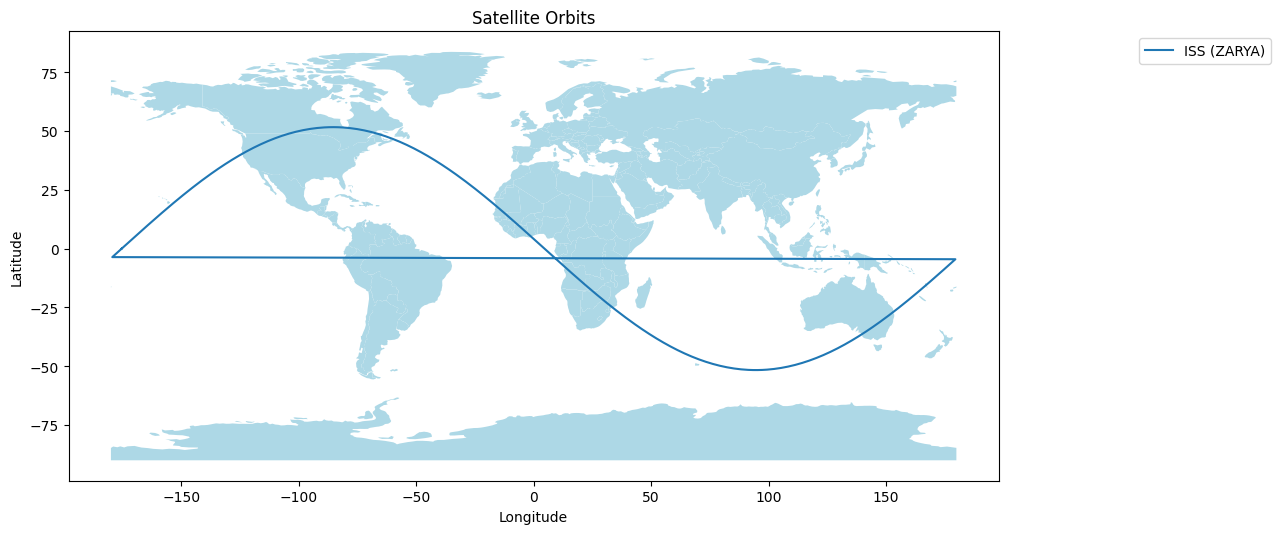

In [12]:
# Load a world map using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightblue')

# Loop through the DataFrame and plot the orbit for each satellite
for idx, row in df.iterrows():
    lat, lon = simulate_orbit(row['inclination'], row['raan'])
    ax.plot(lon, lat, label=row['name'])

# Customize the plot
ax.set_title("Satellite Orbits")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# Show the plot
plt.show()